# Visualize Performance of Cell Health Prediction Models

**Gregory Way, 2019**

For binary classification problem. 

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(cowplot))

In [2]:
results_dir <- "results"
roc_file <- file.path(results_dir, "full_cell_health_roc_results.tsv.gz")
full_roc_df <- readr::read_tsv(roc_file, col_types = readr::cols())

pr_file <- file.path(results_dir, "full_cell_health_pr_results.tsv.gz")
full_pr_df <- readr::read_tsv(pr_file, col_types = readr::cols())

coef_file <- file.path(results_dir, "full_cell_health_coefficients.tsv.gz")
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols())

y_file <- file.path(results_dir, "full_cell_health_y_labels.tsv.gz")
y_df <- readr::read_tsv(y_file, col_types = readr::cols())

## Visualize AUC for each target variable

In [3]:
auroc_df <- full_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit, shuffle, y_transform, min_class_count)
aupr_df <- full_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit, shuffle, y_transform, min_class_count)

auc_df <- dplyr::bind_rows(auroc_df, aupr_df)

auc_df$metric <- dplyr::recode_factor(
    auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

head(auc_df, 2)

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

metric,target,auc,data_fit,shuffle,y_transform,min_class_count
<fct>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
AUROC,cc_all_high_n_spots_h2ax_mean,0.9018822,train,shuffle_true,binarize,151
AUROC,cc_all_high_n_spots_h2ax_mean,0.4224966,test,shuffle_true,binarize,151


## Process Target and Performance Data

In [4]:
# Combine data for downstream processing
y_binary_subset_true_df <- y_df %>%
    dplyr::filter(y_transform == "binarize",
                  y_type == "y_true")

y_binary_subset_pred_df <- y_df %>%
    dplyr::filter(y_transform == "binarize",
                  y_type == "y_pred")

# Process data for plotting
y_plot_df <- y_binary_subset_true_df %>%
    dplyr::inner_join(y_binary_subset_pred_df,
                      by = c("Metadata_profile_id",
                             "target",
                             "data_type",
                             "shuffle",
                             "y_transform"),
                      suffix = c("_true", "_pred"))

y_plot_df$data_type <- dplyr::recode(y_plot_df$data_type,
                                     "train" = "Train",
                                     "test" = "Test")

head(y_plot_df, 3)

Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

Metadata_profile_id,recode_target_value_true,target,data_type,shuffle,y_transform,y_type_true,recode_target_value_pred,y_type_pred
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
profile_346,0,cc_all_high_n_spots_h2ax_mean,Train,shuffle_true,binarize,y_true,-0.4202372,y_pred
profile_185,1,cc_all_high_n_spots_h2ax_mean,Train,shuffle_true,binarize,y_true,0.3158038,y_pred
profile_3,0,cc_all_high_n_spots_h2ax_mean,Train,shuffle_true,binarize,y_true,-0.3043115,y_pred


In [5]:
# Process metric data frame to get subtraction between shuffled and non-shuffled
shuffled_auc_df <- auc_df %>%
    dplyr::filter(shuffle == "shuffle_true") %>%
    dplyr::arrange(metric, target, data_fit)

real_auc_df <- auc_df %>%
    dplyr::filter(shuffle != "shuffle_true") %>%
    dplyr::arrange(metric, target, data_fit)

auc_diff_df <- real_auc_df
auc_diff_df <- auc_diff_df %>%
    dplyr::mutate(auc_diff = real_auc_df$auc - shuffled_auc_df$auc)

# Get factors ready for plotting
auc_diff_df$metric <- factor(auc_diff_df$metric, levels = c("AUROC", "AUPR"))
auc_diff_df$data_fit <- factor(auc_diff_df$data_fit, levels = c("train", "test"))

target_order <- auc_diff_df %>%
    dplyr::filter(metric == "AUROC",
                  data_fit == "test") %>%
    dplyr::arrange(desc(auc_diff))

target_order <- paste(target_order$target)

auc_diff_df$target <- factor(auc_diff_df$target, levels = target_order)

head(auc_diff_df, 3)

metric,target,auc,data_fit,shuffle,y_transform,min_class_count,auc_diff
<fct>,<fct>,<dbl>,<fct>,<chr>,<chr>,<int>,<dbl>
AUROC,cc_all_high_n_spots_h2ax_mean,0.7750343,test,shuffle_false,binarize,151,0.35253772
AUROC,cc_all_high_n_spots_h2ax_mean,0.9550366,train,shuffle_false,binarize,151,0.05315441
AUROC,cc_all_large_notround_polynuclear_mean,0.5226337,test,shuffle_false,binarize,151,-0.11385460


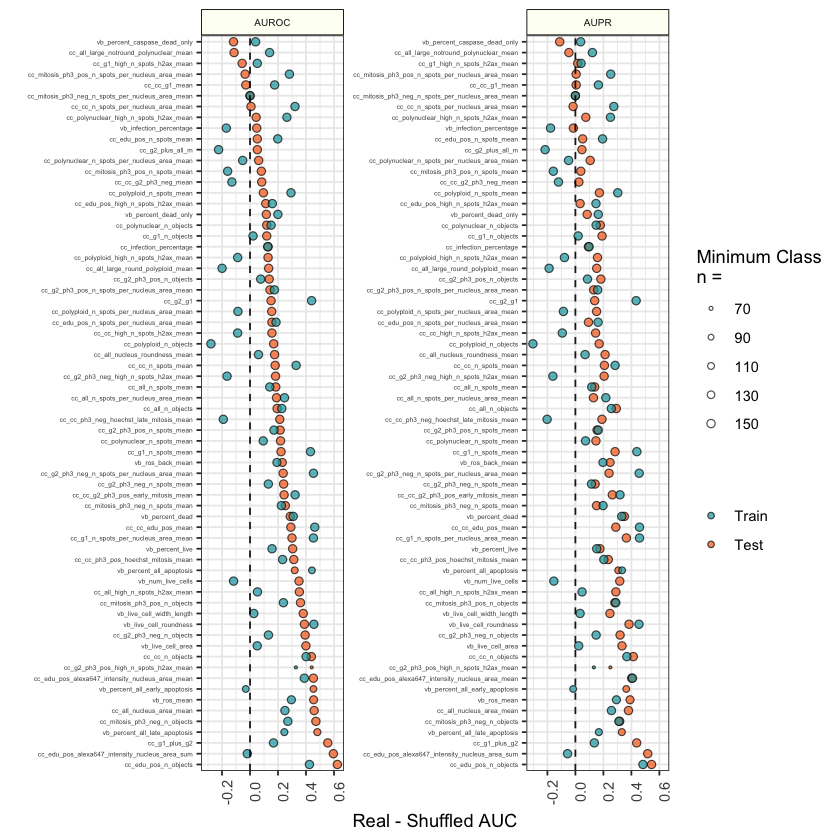

In [6]:
ggplot(auc_diff_df,
       aes(x = target,
           y = auc_diff)) +
    geom_point(aes(size = min_class_count,
                   fill = data_fit),
               alpha = 0.7,
               pch = 21) +
    geom_hline(yintercept = 0,
               linetype = "dashed",
               color="black",
               alpha = 0.9) +
    ylab("Real - Shuffled AUC") +
    xlab("") +
    coord_flip() +
    scale_fill_manual(name = "",
                      values = c("train" = "#0FA3AD",
                                 "test" = "#F76916"),
                      labels = c("train" = "Train",
                                 "test" = "Test")) +
    scale_size_continuous(name = "Minimum Class\nn =",
                          range = c(0.5, 2)) +
    facet_wrap(~metric, nrow = 1, scales="free_y") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90),
          axis.text.y = element_text(size = 4),
          axis.title.y = element_text(size = 8),
          strip.text = element_text(size = 6),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file <- file.path("figures", "cell_health_metric_shuffle_difference_summary.png")
ggsave(file, dpi = 300, width = 9, height = 6)

## Visualize Curves For All Variables

### ROC Curves

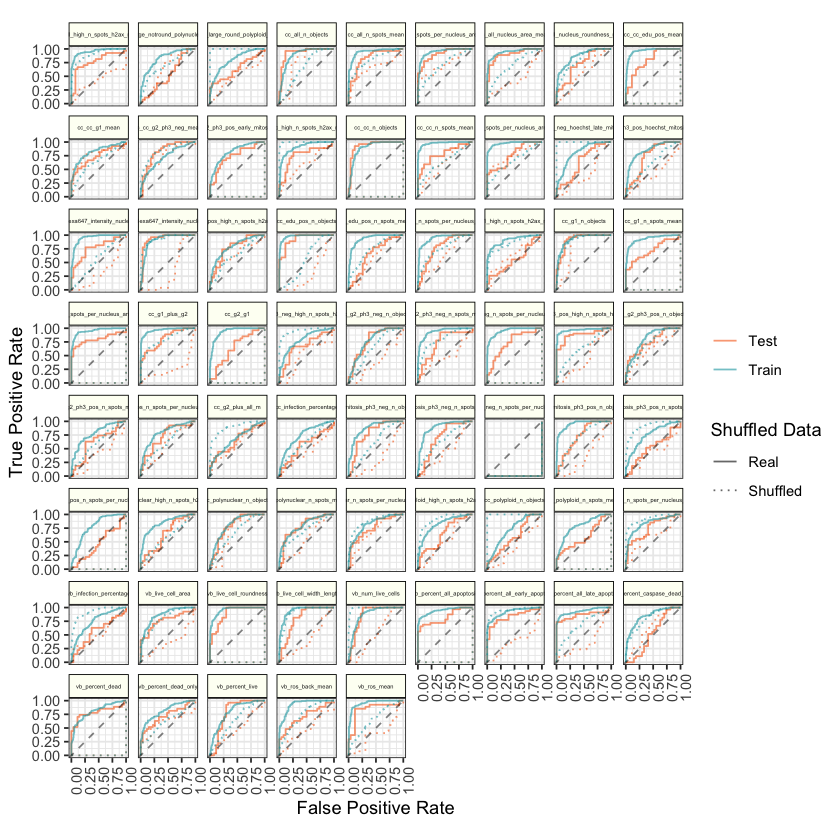

In [7]:
ggplot(full_roc_df, aes(x = fpr, y = tpr)) +
    coord_fixed() +
    facet_wrap(~target) +
    geom_step(aes(color = data_fit,
                  linetype = shuffle),
              alpha = 0.6) +
    geom_abline(intercept = 0,
                slope = 1,
                alpha = 0.5,
                linetype = "dashed") +
    xlab("False Positive Rate") +
    ylab("True Positive Rate") +
    scale_color_manual(name = "",
                       values = c("train" = "#0FA3AD",
                                  "test" = "#F76916"),
                       labels = c("train" = "Train",
                                  "test" = "Test")) +
    scale_linetype_manual(name = "Shuffled Data",
                          values = c("shuffle_true" = "dotted",
                                     "shuffle_false" = "solid"),
                          labels = c("shuffle_true" = "Shuffled",
                                     "shuffle_false" = "Real")) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = 90),
        strip.text = element_text(size = 3.5),
        strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")
    )

file <- file.path("figures", "roc_curves.png")
ggsave(file, dpi = 300, width = 9, height = 9)

### PR Curves

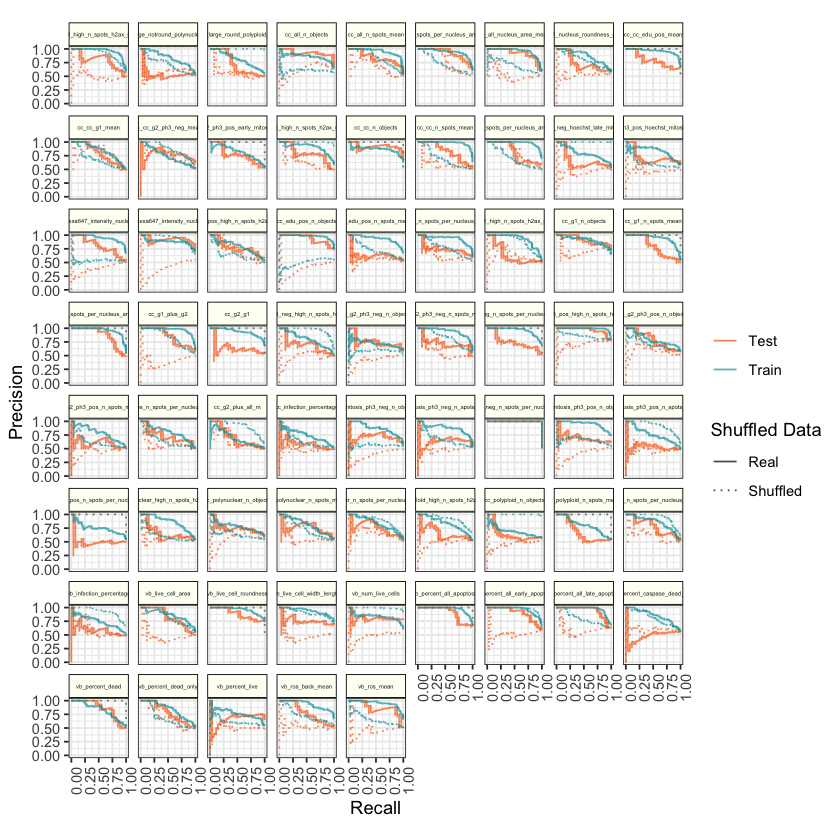

In [8]:
ggplot(full_pr_df, aes(x = recall, y = precision)) +
    coord_fixed() +
    facet_wrap(~target) +
    geom_step(aes(color = data_fit,
                  linetype = shuffle),
              alpha = 0.7) +
    xlab("Recall") +
    ylab("Precision") +
    scale_color_manual(name = "",
                       values = c("train" = "#0FA3AD",
                                  "test" = "#F76916"),
                       labels = c("train" = "Train",
                                  "test" = "Test")) +
    scale_linetype_manual(name = "Shuffled Data",
                          values = c("shuffle_true" = "dotted",
                                     "shuffle_false" = "solid"),
                          labels = c("shuffle_true" = "Shuffled",
                                     "shuffle_false" = "Real")) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = 90),
        strip.text = element_text(size = 3.5),
        strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")
    )

file <- file.path("figures", "pr_curves.png")
ggsave(file, dpi = 300, width = 9, height = 9)

## Output Performance Metrics for Individual Target Variables

In [9]:
label_thresh_value = 0.90

pdf_file <- file.path("figures", "all_classification_performance_metrics.pdf")
pdf(pdf_file, width = 6, height = 8, onefile = TRUE)

for (target in unique(full_roc_df$target)) {
    subset_roc_df <- full_roc_df %>%
        dplyr::filter(target == !!target)

    subset_pr_df <- full_pr_df %>%
        dplyr::filter(target == !!target)
    
    # Plot ROC Curves
    roc_gg <-
        ggplot(subset_roc_df,
               aes(x = fpr,
                   y = tpr)) +
        geom_step(aes(color = data_fit,
                      linetype = shuffle),
                  alpha = 0.6) +
        geom_abline(intercept = 0,
                    slope = 1,
                    alpha = 0.5,
                    linetype = "dashed") +
        xlab("False Positive Rate") +
        ylab("True Positive Rate") +
        scale_color_manual(name = "",
                           values = c("train" = "#0FA3AD",
                                      "test" = "#F76916"),
                           labels = c("train" = "Train",
                                      "test" = "Test")) +
        scale_linetype_manual(name = "Shuffled Data",
                              values = c("shuffle_true" = "dotted",
                                         "shuffle_false" = "solid"),
                              labels = c("shuffle_true" = "Shuffled",
                                         "shuffle_false" = "Real")) +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90),
              strip.text = element_text(size = 3.5),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))
    # Plot PR Curves
    pr_gg <- ggplot(subset_pr_df,
                    aes(x = recall,
                        y = precision)) +
        geom_step(aes(color = data_fit,
                      linetype = shuffle),
                  alpha = 0.7) +
        xlab("Recall") +
        ylab("Precision") +
        ylim(c(0, 1)) +
        xlim(c(0, 1)) +
        scale_color_manual(name = "",
                           values = c("train" = "#0FA3AD",
                                      "test" = "#F76916"),
                           labels = c("train" = "Train",
                                      "test" = "Test")) +
        scale_linetype_manual(name = "Shuffled Data",
                              values = c("shuffle_true" = "dotted",
                                         "shuffle_false" = "solid"),
                              labels = c("shuffle_true" = "Shuffled",
                                         "shuffle_false" = "Real")) +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90),
              strip.text = element_text(size = 3.5),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))
    
    # Plot Machine Learning Coefficients
    subset_coef_df <- full_coef_df %>%
        dplyr::filter(target == !!target,
                      shuffle == "shuffle_false",
                      y_transform == "binarize") %>%
        dplyr::mutate(weight_rank = row_number(weight))
    
    # Setup labeling thresholds
    non_zero_coef <- subset_coef_df$abs_weight[subset_coef_df$abs_weight > 0]
    label_thresh <- quantile(non_zero_coef, label_thresh_value)
    label_logic <- subset_coef_df$abs_weight > label_thresh

    coef_gg <-
        ggplot(subset_coef_df,
               aes(x = weight_rank,
                   y = weight)) +
        geom_point(size = 0.2,
                   alpha = 0.6) +
        xlab("Weight Rank") +
        ylab("Weight") +
        geom_text_repel(data = subset(subset_coef_df, label_logic),
                        arrow = arrow(length = unit(0.01, "npc")),
                        box.padding = 0.4,
                        point.padding = 0.1,
                        segment.size = 0.5,
                        segment.alpha = 0.6,
                        size = 1.5,
                        fontface = "italic",
                        aes(label = feature,
                            x = weight_rank,
                            y = weight)) +
        theme_bw()
    
    # Isolate feature
    y_binary_subset_df <- y_plot_df %>%
        dplyr::filter(target == !!target)

    y_binary_subset_df$plot_group <- paste0(y_binary_subset_df$recode_target_value_true,
                                            y_binary_subset_df$shuffle)
    
    feature_distrib_gg <-
        ggplot(y_binary_subset_df,
               aes(x = factor(recode_target_value_true),
                   y = recode_target_value_pred,
                   color = shuffle,
                   group = plot_group)) +
        scale_color_manual(name = "Shuffled",
                       labels = c("shuffle_true" = "True",
                                  "shuffle_false" = "False"),
                       values = c("shuffle_true" = "#614650",
                                  "shuffle_false" = "#62936D")) +
        facet_wrap(~data_type) +
        geom_boxplot(outlier.alpha = 0) +
        geom_point(alpha = 0.5,
                   size = 0.3,
                   position = position_jitterdodge(jitter.width = 0.2)) +
        theme_bw() +
        theme(strip.text = element_text(size = 8),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4")) +
        xlab("Binarize") +
        ylab("Prediction")
    
    # Build table for plotting AUC
    auroc_auc_df <- subset_roc_df %>%
        dplyr::distinct(auc, data_fit, shuffle, min_class_count) %>%
        dplyr::rename(auroc = auc) %>%
        dplyr::left_join(
            subset_pr_df %>%
                dplyr::distinct(auc, data_fit, shuffle, min_class_count) %>%
                dplyr::rename(aupr = auc),
            by = c("data_fit", "shuffle", "min_class_count")
        ) %>%
        dplyr::select(auroc, aupr, data_fit, shuffle, min_class_count) %>%
        dplyr::mutate(auroc = round(auroc, 2), aupr = round(aupr, 2))

    auroc_auc_df$shuffle <- dplyr::recode(auroc_auc_df$shuffle,
                                          shuffle_true = "True",
                                          shuffle_false = "False")
    auroc_auc_df$data_fit <- dplyr::recode(auroc_auc_df$data_fit,
                                           train = "Train",
                                           test = "Test")
    auroc_auc_df <- auroc_auc_df %>%
        dplyr::arrange(shuffle) %>%
        dplyr::rename(n = min_class_count, fit = data_fit)
    
    # Plot all performance metrics together with cowplot
    table_theme <- gridExtra::ttheme_default(
        core = list(fg_params=list(cex = 0.5)),
        colhead = list(fg_params=list(cex = 0.6))
    )

    table_gg <- gridExtra::tableGrob(auroc_auc_df,
                                     theme = table_theme,
                                     rows = NULL)
    legend_gg <- cowplot::get_legend(roc_gg +
                                     theme(legend.background = element_rect(fill = "transparent")))

    top_right_panel_gg <- cowplot::plot_grid(
        legend_gg,
        table_gg,
        NULL,
        nrow = 3,
        rel_heights = c(1, 1, 0.2)
    )
    
    top_row_perf_gg <- cowplot::plot_grid(
        roc_gg + theme(legend.position = "none"),
        pr_gg + theme(legend.position = "none"),
        top_right_panel_gg,
        ncol = 3,
        labels = c("a", "b", ""),
        rel_widths = c(1, 1, 0.8)
    )

    bottom_row_perf_gg <- cowplot::plot_grid(
        coef_gg,
        feature_distrib_gg,
        ncol = 2,
        labels = c("c", "d")
    )

    performance_gg <- cowplot::plot_grid(
        top_row_perf_gg,
        bottom_row_perf_gg,
        nrow = 2,
        ncol = 1,
        labels = c("", "")
    )

    target_title <- ggdraw() + 
      draw_label(
        paste("Performance:", target),
        fontface = 'bold',
        x = 0,
        hjust = 0
      ) +
      theme(
        plot.margin = margin(0, 0, 0, 7)
      )
    
    performance_gg <- cowplot::plot_grid(
        target_title,
        performance_gg,
        ncol = 1,
        rel_heights = c(0.1, 1)
    )
    
    # Save figure
    cowplot_file <- file.path("figures",
                              "target_performance",
                              "binary",
                              paste0(target, "_performance.png"))
    
    cowplot::save_plot(filename = cowplot_file,
                       plot = performance_gg,
                       base_height = 6,
                       base_width = 8)
    
    print(performance_gg)
}

dev.off()

pdf 
  2